### Imports
https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from tsfresh import extract_features
from xgboost import XGBClassifier, plot_tree

%run plot.py

/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Read data

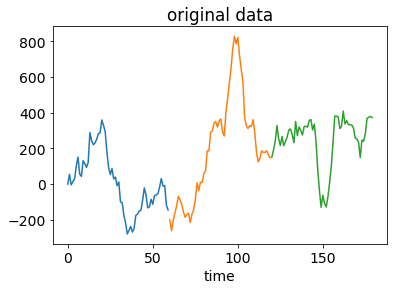

data:  10000
sample length:  60


In [19]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"original data")

# note: here it does not need to be converted to the 3-bit version, a label remains y[i]=0,1,2
y = np.loadtxt(fnamey, dtype=int)
n_class = 3    #  = len(np.unique(y))
print('data: ',N)
print('sample length: ',L)

### (do not) Rescale data
We know that the average value of a sample is not relevant: let's see if XGBoost works if we do not remove such average and we do not standardize data

In [3]:
RESCALE=False
if RESCALE:
    #remove average value of each sample from its values
    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]-xm[i]

    #rescale (crude version, variance should be used)
    x = x/400

    Show_data(x,L,"rescaled data")

## TSFRESH: extract features

Input data format: DATAFRAME

first column $\to$ id of the sample 

second column $\to$  id of the time step

third column $\to$ value of the feature of _id_-sample at _id_-step

For more: https://tsfresh.readthedocs.io/en/latest/text/data_formats.html

In [4]:
def get_df(x):
    '''Build input dataframe for given data series
    Input:
    var = array of time series, (#samples,time,1)
    Return:
    df = dataframe ready for features extraction
    '''
    
    #N = #samples, t = timesteps
    N, t = x.shape[0], x.shape[1]
    #build id columns
    id_col = np.repeat(np.arange(N),t)
    #build time columns
    time_col = np.tile(np.arange(t),N)
    #build var columns
    x_col = x.flatten()
      
    #build dict for df
    x_dict = {'id':id_col,'time':time_col,'value':x_col}
        
    #return dataframe
    return pd.DataFrame(x_dict)

In [5]:
#get df
df = get_df(x) 

#check that last columns, if reshaped is equal to x
#df_to_array = df.values[:,-1].reshape(x.shape[0],x.shape[1])
#sum of different values: should be 0
#print('Differences:',np.sum(df_to_array != x))

df

,id,time,value
0,0,0,0.0
1,0,1,55.0
2,0,2,-4.0
3,0,3,14.0
4,0,4,30.0
...,...,...,...
599995,9999,55,2990454.0
599996,9999,56,2990473.0
599997,9999,57,2990517.0
599998,9999,58,2990583.0


In [6]:
#extract features
x_features = extract_features(
                            df, #our dataframe
                            column_id='id', #sample id, from 0 to N
                            column_sort='time', #timestep, from 0 to t
                            column_kind=None, #we have only one feature
                            column_value='value', #value of input 
                            n_jobs=4) #number of cores

Feature Extraction:   0%|                                                                                            | 0/20 [00:00<?, ?it/s]/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index w

In [7]:
#look at x_features
x_features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_2,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1
0,1.0,0.0,0.0,1.0,564.0,1.595054e+06,42.491525,-2.457627,-0.706897,-2.0,...,0.239217,0.239217,0.283936,0.283936,0.793400,1.634550,2.614319,3.341064,3.700275,3.850934
1,1.0,0.0,0.0,1.0,11870.0,7.395812e+06,48.118644,5.881356,0.396552,186.0,...,0.142506,0.142506,0.283936,0.424254,0.973558,1.638909,2.666253,3.307769,3.676328,3.834951
2,1.0,0.0,0.0,1.0,14800.0,4.756902e+06,48.542373,3.762712,-0.405172,280.0,...,0.239217,0.473981,0.473981,0.611952,1.265251,1.731698,2.946410,3.629268,3.856101,3.937640
3,1.0,0.0,0.0,1.0,14457.0,4.017395e+06,43.491525,-2.406780,-0.017241,254.0,...,0.317937,0.317937,0.518700,0.701390,2.256285,1.751159,3.018981,3.718945,3.956922,3.988984
4,1.0,0.0,0.0,1.0,41150.0,3.190260e+07,45.694915,9.694915,-0.172414,775.5,...,0.239217,0.283936,0.424254,0.563420,1.107653,1.689926,2.744013,3.337036,3.651123,3.834951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,0.0,0.0,1.0,179369274.0,5.362223e+14,57.677966,-0.762712,0.577586,2989553.0,...,0.384543,0.457102,0.656671,0.838120,0.973558,1.643572,2.582843,3.294830,3.639092,3.757935
9996,1.0,0.0,0.0,1.0,179377349.0,5.362706e+14,41.084746,6.711864,-0.612069,2989618.5,...,0.239217,0.283936,0.283936,0.659243,1.876251,1.707294,2.760877,3.492872,3.871793,3.988984
9997,1.0,0.0,0.0,1.0,179408463.0,5.364566e+14,48.322034,-3.949153,-0.922414,2990094.5,...,0.239217,0.379535,0.518700,0.701390,0.973558,1.662535,2.706452,3.443361,3.720561,3.860623
9998,1.0,0.0,0.0,1.0,179396496.0,5.363851e+14,53.457627,10.474576,-0.258621,2989871.0,...,0.239217,0.283936,0.283936,0.424254,0.838120,1.658728,2.626119,3.235975,3.453141,3.578230


In [8]:
#remove columns with NaN or inf
x_features.replace([np.inf, -np.inf], np.nan)
x_features = x_features.dropna(axis='columns')

In [9]:
#look at clean x_features
x_features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_2,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1
0,1.0,0.0,0.0,1.0,564.0,1.595054e+06,42.491525,-2.457627,-0.706897,-2.0,...,0.239217,0.239217,0.283936,0.283936,0.793400,1.634550,2.614319,3.341064,3.700275,3.850934
1,1.0,0.0,0.0,1.0,11870.0,7.395812e+06,48.118644,5.881356,0.396552,186.0,...,0.142506,0.142506,0.283936,0.424254,0.973558,1.638909,2.666253,3.307769,3.676328,3.834951
2,1.0,0.0,0.0,1.0,14800.0,4.756902e+06,48.542373,3.762712,-0.405172,280.0,...,0.239217,0.473981,0.473981,0.611952,1.265251,1.731698,2.946410,3.629268,3.856101,3.937640
3,1.0,0.0,0.0,1.0,14457.0,4.017395e+06,43.491525,-2.406780,-0.017241,254.0,...,0.317937,0.317937,0.518700,0.701390,2.256285,1.751159,3.018981,3.718945,3.956922,3.988984
4,1.0,0.0,0.0,1.0,41150.0,3.190260e+07,45.694915,9.694915,-0.172414,775.5,...,0.239217,0.283936,0.424254,0.563420,1.107653,1.689926,2.744013,3.337036,3.651123,3.834951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,0.0,0.0,1.0,179369274.0,5.362223e+14,57.677966,-0.762712,0.577586,2989553.0,...,0.384543,0.457102,0.656671,0.838120,0.973558,1.643572,2.582843,3.294830,3.639092,3.757935
9996,1.0,0.0,0.0,1.0,179377349.0,5.362706e+14,41.084746,6.711864,-0.612069,2989618.5,...,0.239217,0.283936,0.283936,0.659243,1.876251,1.707294,2.760877,3.492872,3.871793,3.988984
9997,1.0,0.0,0.0,1.0,179408463.0,5.364566e+14,48.322034,-3.949153,-0.922414,2990094.5,...,0.239217,0.379535,0.518700,0.701390,0.973558,1.662535,2.706452,3.443361,3.720561,3.860623
9998,1.0,0.0,0.0,1.0,179396496.0,5.363851e+14,53.457627,10.474576,-0.258621,2989871.0,...,0.239217,0.283936,0.283936,0.424254,0.838120,1.658728,2.626119,3.235975,3.453141,3.578230


### Split train/val

In [10]:
#split data into training and validation

perc_train=0.8
N_train = int(perc_train*N)
x_train = x_features[:N_train]
y_train = y[:N_train]
x_val = x_features[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  n_class=',n_class)

#rescale: in each feature, remove average and divide by std
if True:
    average = np.mean(x_train,axis=0)
    x_train -= average
    x_val -= average

    std = np.std(x_train,axis=0)
    x_train /= std
    x_val /= std

N_train= 8000   N_val= 2000   n_class= 3


In [11]:
#look at x_train
x_train

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_2,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1
0,NaN,-0.154284,-0.153858,0.185094,-1.722010,-1.115848,-0.613516,-1.142157,-1.176963,-1.722029,...,0.269724,-0.528468,-0.797033,-1.353684,-1.055579,-0.188134,-0.241585,-0.057354,-0.013214,-0.021569
1,NaN,-0.154284,-0.153858,0.185094,-1.721736,-1.115847,0.267181,0.145533,0.640790,-1.721756,...,-0.976003,-1.305134,-0.797033,-0.686134,-0.638879,-0.128839,0.074068,-0.221816,-0.152983,-0.150596
2,NaN,-0.154284,-0.153858,0.185094,-1.721665,-1.115848,0.333499,-0.181624,-0.679921,-1.721619,...,0.269724,1.356870,0.347882,0.206820,0.035800,1.133527,1.776868,1.366229,0.896288,0.678419
3,NaN,-0.154284,-0.153858,0.185094,-1.721674,-1.115848,-0.457006,-1.134305,-0.040867,-1.721657,...,1.283704,0.103712,0.617290,0.632314,2.328035,1.398283,2.217958,1.809191,1.484748,1.092926
4,NaN,-0.154284,-0.153858,0.185094,-1.721027,-1.115847,-0.112155,0.734415,-0.296489,-1.720899,...,0.269724,-0.169339,0.048304,-0.024067,-0.328722,0.565230,0.546694,-0.077251,-0.300098,-0.150596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,NaN,-0.154284,-0.153858,0.185094,1.718389,2.214908,-0.687791,-0.561126,0.143748,1.718375,...,-0.976003,-0.169339,-0.797033,-0.686134,-0.638879,0.216571,0.317316,0.447943,0.399416,0.678419
7996,NaN,-0.154284,-0.153858,0.185094,1.718249,2.214637,1.479465,-0.846407,1.762683,1.718204,...,0.269724,-0.528468,-0.797033,-0.236815,-0.952145,0.821961,1.113107,0.937058,0.840761,0.885672
7997,NaN,-0.154284,-0.153858,0.185094,1.717763,2.213695,0.259223,-1.280871,1.947299,1.717809,...,1.283704,1.356870,1.448486,1.282792,-0.638879,0.637887,-0.658661,-1.071663,-1.238314,-1.510120
7998,NaN,-0.154284,-0.153858,0.185094,1.717885,2.213931,-0.443743,-0.760037,0.172150,1.717856,...,-0.976003,-1.305134,-0.797033,-1.353684,0.223887,1.029606,1.021282,1.099384,1.043403,0.885672


## XGB

In [12]:
# reproducibility
np.random.seed(12345)

#define parameters for xgboost
params = {'max_depth':6,'min_child_weight':1,\
          'learning_rate':0.3,'use_label_encoder':False}

#build model with given params
model = XGBClassifier(**params)

#fit
model.fit(x_train.values,y_train)

[12:51:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

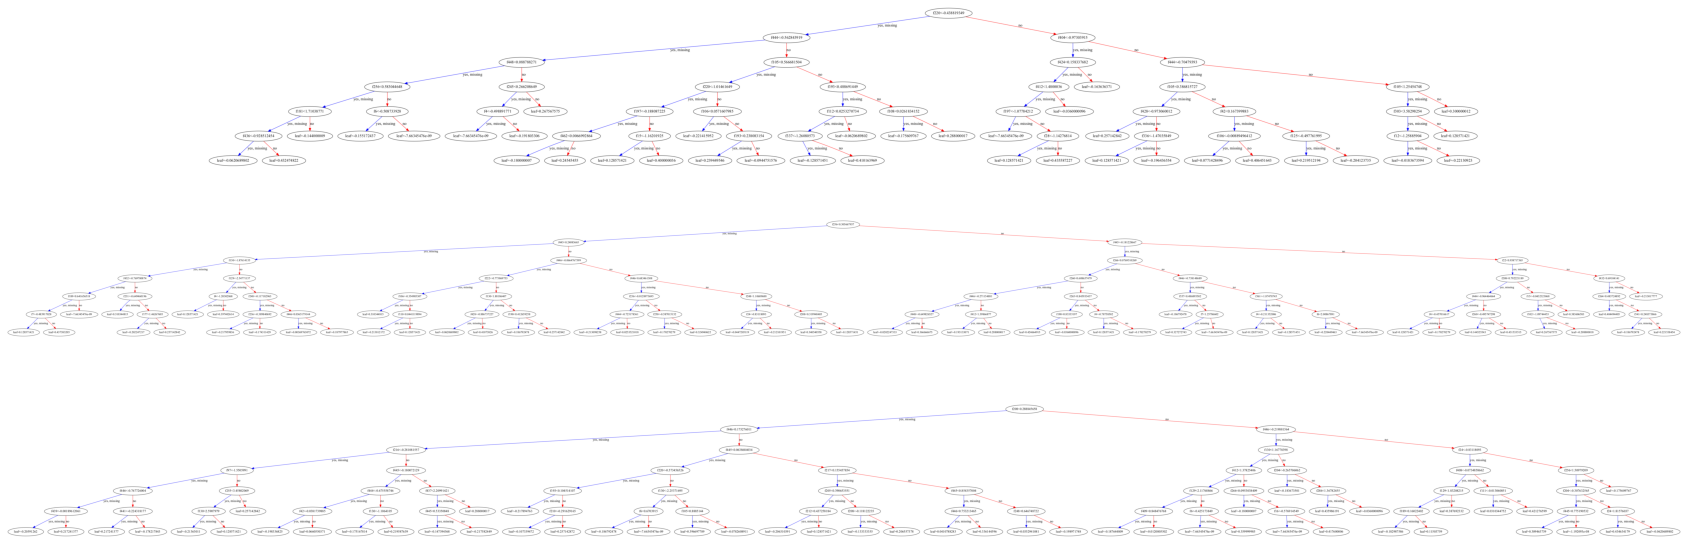

In [13]:
#plot tree

fig, AX = plt.subplots(3,1,figsize=(30, 10))
for i in range(3):
    ax=AX[i]
    plot_tree(model, num_trees=i, ax=ax)
    
fig.savefig("DATA/trees-time-ser.png", dpi=300, pad_inches=0.02)

In [14]:
from sklearn.metrics import accuracy_score

#predict labels on training set
y_pred_train = model.predict(x_train)
#predict labels on validation set
y_pred_val = model.predict(x_val)

y_pred_val_soft = model.predict_proba(x_val)



#compute accuracies
acc_train = accuracy_score(y_train,y_pred_train) 
acc_val = accuracy_score(y_val,y_pred_val)

#print accuracies
print('Training accuracy:',acc_train)
print('Validation accuracy:',acc_val)

Training accuracy: 1.0
Validation accuracy: 0.9655


/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


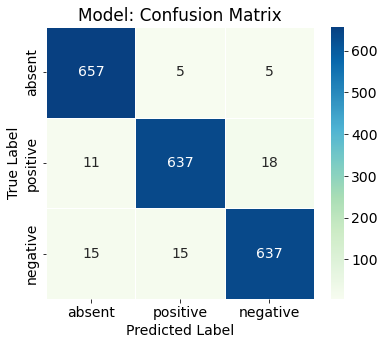

In [15]:
import seaborn as sns
from sklearn import metrics

LABELS = ["absent","positive","negative"]
cmap="GnBu"

def show_confusion_matrix(validations, predictions, label="Model"):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d',
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_val = model.predict(x_val)
show_confusion_matrix(y_val, y_pred_val)

### Feature importances

See an overview of extracted features:
https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html

In [16]:
#get feature names
feature_names = x_features.columns.values

#empty dict
feat_imp = {}
#get f importance from model
for i,f in enumerate(feature_names):
    feat_imp[f] = model.feature_importances_[i]
#sort features depending on their importances
feat_imp = dict(sorted(feat_imp.items(), reverse=True, key=lambda item: item[1]))

In [17]:
minval=0.005
print('------------- Feature importance sum = '+str(np.sum(model.feature_importances_)))
print('------------- Showing feature with importance > '+str(minval))
for i,k in enumerate(feat_imp.keys()):
    if feat_imp[k]>minval: print(i+1,k,feat_imp[k])

------------- Feature importance sum = 1.0
------------- Showing feature with importance > 0.005
1 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0 0.121052146
2 value__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0 0.11816074
3 value__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0 0.115540884
4 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4 0.10869414
5 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6 0.07525927
6 value__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var" 0.03929884
7 value__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" 0.013904627
8 value__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min" 0.012297046
9 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.012080891
10 value__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0 0.010773397
11 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2 0.009558431
12 value__change_quantiles

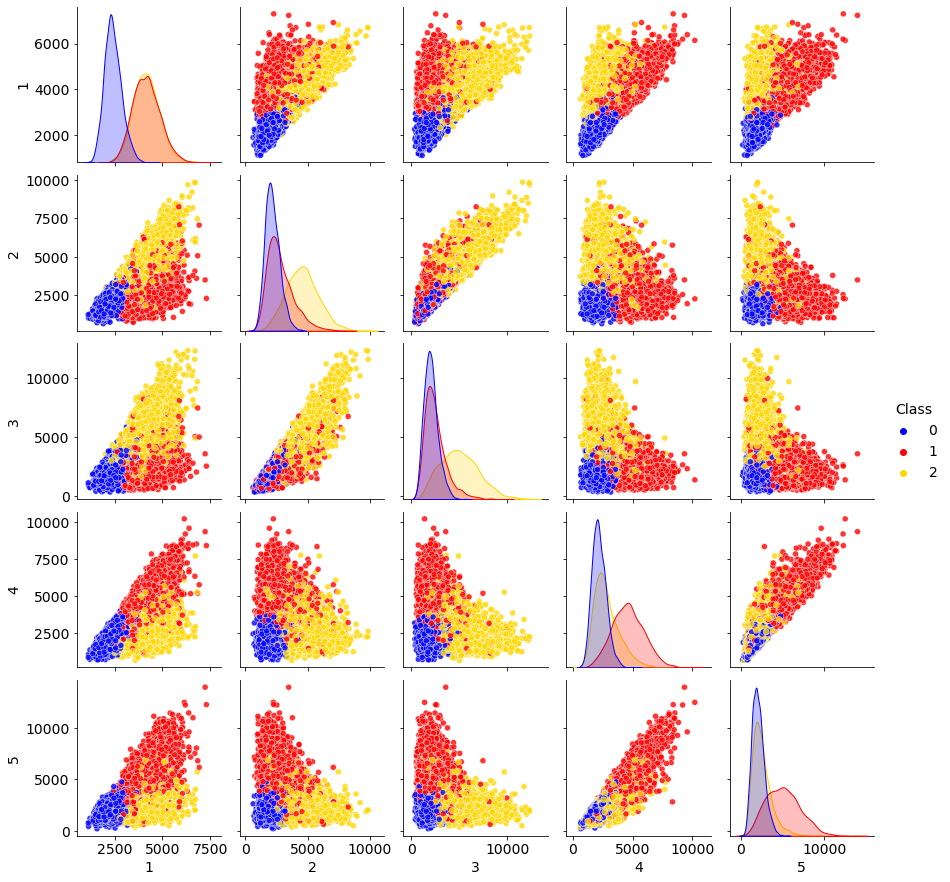

In [18]:
#get feature names given importance order
features = list(feat_imp.keys())

#build dataframe for sns pairplot
df = pd.DataFrame({'1':x_features[features[0]],\
                   '2':x_features[features[1]],\
                   '3':x_features[features[2]],\
                   '4':x_features[features[3]],\
                   '5':x_features[features[4]],\
                   'Class':y})
#pairplot with seaborn
pal = sns.blend_palette(["blue","red","gold"],n_class)
sns.pairplot(df,hue='Class',plot_kws=dict(alpha=0.8),palette=pal);